<a href="https://colab.research.google.com/github/minjaekim070/Bootcamp_Project/blob/main/LSTM%EB%AA%A8%EB%8D%B8%20%EC%9D%B4%EC%83%81%EC%B9%98%20%ED%83%90%EC%A7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 업로드

In [ ]:
#라이브러리
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [ ]:
!unzip drive/MyDrive/AnomalyDetection/archive.zip

Archive:  drive/MyDrive/AnomalyDetection/archive.zip
replace README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#데이터 전처리 및 시각화


In [ ]:
#데이터 읽기
df = pd.read_csv('realKnownCause/realKnownCause/ambient_temperature_system_failure.csv')
df.head()
"""
The ambient temperature in an office
setting.
"""

'\nThe ambient temperature in an office\nsetting.\n'

In [ ]:
#데이터 형태 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB


In [ ]:
#데이터 확인
df.describe()

,value
count,7267.000000
mean,71.242433
std,4.247509
min,57.458406
25%,68.369411
50%,71.858493
75%,74.430958
max,86.223213


In [ ]:
#데이터 전처리
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['C_value'] = (df['value'] -32 )* (5/9) # 화씨 -> 섭씨
ambient_temp_data = df

<Axes: xlabel='timestamp'>

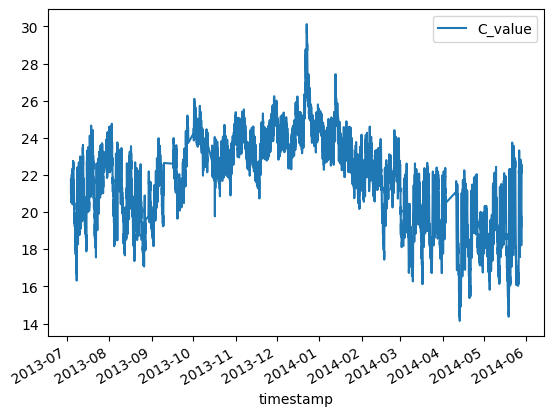

In [ ]:
#전체 데이터 시각화
df.plot(x='timestamp', y='C_value')

In [ ]:
#주말/평일, 낮/밤에 따른 분포를 확인하기 위해 데이터 분류
#시간,날짜에 따라 데이터를 분류해서 분석
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <=20 )).astype(int)

df['Day'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['Day'] < 5).astype(int)

In [ ]:
#시간을 정수형으로 변환
#시간을 구분할 수 있는 적절한 값 사용
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)
df['time_epoch']

0       13728960
1       13728996
2       13729032
3       13729068
4       13729104
          ...   
7262    14012748
7263    14012784
7264    14012820
7265    14012856
7266    14012892
Name: time_epoch, Length: 7267, dtype: int64

In [ ]:
#데이터프레임 확인
df

,timestamp,value,C_value,hours,daylight,Day,WeekDay,time_epoch
0,2013-07-04 00:00:00,69.880835,21.044908,0,0,3,1,13728960
1,2013-07-04 01:00:00,71.220227,21.789015,1,0,3,1,13728996
2,2013-07-04 02:00:00,70.877805,21.598781,2,0,3,1,13729032
3,2013-07-04 03:00:00,68.959400,20.533000,3,0,3,1,13729068
4,2013-07-04 04:00:00,69.283551,20.713084,4,0,3,1,13729104
...,...,...,...,...,...,...,...,...
7262,2014-05-28 11:00:00,72.370206,22.427892,11,1,2,1,14012748
7263,2014-05-28 12:00:00,72.172956,22.318309,12,1,2,1,14012784
7264,2014-05-28 13:00:00,72.046565,22.248092,13,1,2,1,14012820
7265,2014-05-28 14:00:00,71.825226,22.125126,14,1,2,1,14012856


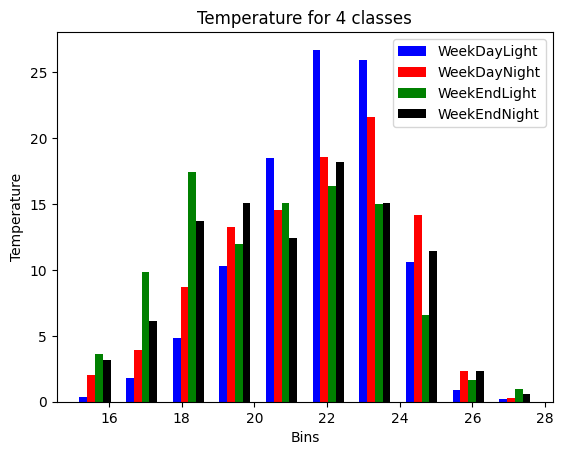

In [ ]:
#평일:1, 주말:0 / 낮:1, 밤:0
df['categories'] = df['WeekDay'] * 10 + df['daylight']
#평일 낮11 평일밤10 주말낮1 주말밤0
a = df.loc[df['categories'] == 11, 'C_value']
b = df.loc[df['categories'] == 10, 'C_value']
c = df.loc[df['categories'] == 1, 'C_value']
d = df.loc[df['categories'] == 0, 'C_value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins = a_bins)
c_heights, c_bins = np.histogram(c, bins = a_bins)
d_heights, d_bins = np.histogram(d, bins = a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekDayLight')
ax.bar(b_bins[:-1]+width, b_heights*100/b.count(), width=width, facecolor='red', label='WeekDayNight')
ax.bar(c_bins[:-1]+width*2, c_heights*100/c.count(), width=width, facecolor='green', label='WeekEndLight')
ax.bar(d_bins[:-1]+width*3, d_heights*100/d.count(), width=width, facecolor='black', label='WeekEndNight')

plt.legend()
plt.title('Temperature for 4 classes')
plt.xlabel('Bins')
plt.ylabel('Temperature')
plt.show()

Text(0.5, 1.0, 'WeekEndNight')

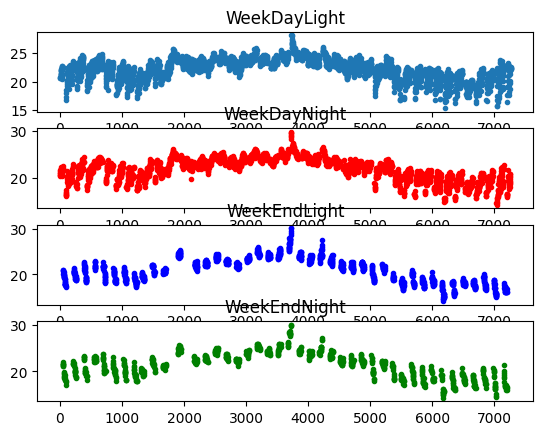

In [ ]:
#평일/주말, 낮/밤에 대한 온도 그래프
ax1 = plt.subplot(4,1,1)
plt.plot(a,'.')
plt.title('WeekDayLight')

ax2 = plt.subplot(4,1,2, sharex = ax1)
plt.plot(b,'r.')
plt.title('WeekDayNight')

ax3 = plt.subplot(4,1,3, sharex = ax1)
plt.plot(c,'b.')
plt.title('WeekEndLight')

ax4 = plt.subplot(4,1,4, sharex = ax1)
plt.plot(d,'g.')
plt.title('WeekEndNight')

In [ ]:
#평일 낮, 평일 밤, 주말 낮, 주말 밤으로 class를 나눠서 여러 그래프로 분석해봤을 때
#모두 비슷한 양상을 보이다가
#time_epoch 기준으로 3000~5000사이에서 평균값에서 크게 벗어나는 양상을 보임.

# 이상탐지(LSTM_AE)

4가지 클래스 모두 비슷한 양상을 보였기 때문에 구분하는 건 의미없다고 판단하여 제외하고 데이터를 재구성

In [ ]:
#데이터 재구성
data = df[['C_value', 'time_epoch']]
data

,C_value,time_epoch
0,21.044908,13728960
1,21.789015,13728996
2,21.598781,13729032
3,20.533000,13729068
4,20.713084,13729104
...,...,...
7262,22.427892,14012748
7263,22.318309,14012784
7264,22.248092,14012820
7265,22.125126,14012856


In [ ]:
#Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
scaled_df = pd.DataFrame(scaled_data)
scaled_df.columns = ['C_value', 'time_epoch']
scaled_df

,C_value,time_epoch
0,0.431862,0.000000
1,0.478426,0.000127
2,0.466521,0.000254
3,0.399829,0.000380
4,0.411098,0.000507
...,...,...
7262,0.518404,0.999493
7263,0.511547,0.999620
7264,0.507153,0.999746
7265,0.499458,0.999873


기존의 그래프를 확인했을 때 별다른 변수가 없고 시간에 따른 온도에 대한 data만 존재
1500~4000사이에서 온도가 치솟은 부분이 이상치일 수있음을 가정하여 data를 분리.

In [ ]:
#모델 학습 및 검증을 위한 data 분리

train_set_1 = scaled_df.iloc[0:1500,:]
train_set_2 =  scaled_df.iloc[4000:5000,:]
train_set = pd.concat([train_set_1, train_set_2])
test_set_1 = scaled_df.iloc[1500:4000,:]
test_set_2 = scaled_df.iloc[5000:,:]

In [ ]:
#LSTM 라이브러리
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from keras.models import Sequential

#전체 이상치
total_anomalies=[]

# DataFrame을 배열로 변환
train_set_array = train_set.values

# 입력 데이터 형태 변환
train_set_array = train_set_array.reshape(train_set_array.shape[0], train_set_array.shape[1], 1)

# 모델 구성
model = Sequential()
model.add(LSTM(64, activation='relu'))
model.add(Dense(train_set_array.shape[1]))  # 유닛 수를 변경
model.compile(optimizer='adam', loss='mse')

# 모델 학습
model.fit(train_set_array, train_set_array, epochs=20, batch_size=32)

Epoch 1/20
79/79 [==============================] - 1s 3ms/step - loss: 0.1010
Epoch 2/20
79/79 [==============================] - 0s 2ms/step - loss: 0.0174
Epoch 3/20
79/79 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 4/20
79/79 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 5/20
79/79 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 6/20
79/79 [==============================] - 0s 2ms/step - loss: 3.1866e-04
Epoch 7/20
79/79 [==============================] - 0s 2ms/step - loss: 4.3240e-05
Epoch 8/20
79/79 [==============================] - 0s 4ms/step - loss: 1.5970e-05
Epoch 9/20
79/79 [==============================] - 0s 4ms/step - loss: 1.3534e-05
Epoch 10/20
79/79 [==============================] - 0s 3ms/step - loss: 1.2626e-05
Epoch 11/20
79/79 [==============================] - 0s 4ms/step - loss: 1.1959e-05
Epoch 12/20
79/79 [==============================] - 0s 3ms/step - loss: 1.1383e-05
Epoch 13/20
79/79 [==

AutoEncoder 기법 사용.
AutoEncoder-입력 데이터를 재구성하여, 재구성한 데이터를 기존 데이터와 비교해봄으로써 발생하는 오차가 클 수록 이상치에 가깝다고 판단.

In [ ]:
#test_set_1 이상탐지

reconstructions = model.predict(test_set_1)
mse = np.mean(np.power(test_set_1 - reconstructions, 2), axis=1)
threshold = np.mean(mse) + 3 * np.std(mse) #평균값으로 부터 멀 수록 이상치에 가깝다고 가정

anomalies = np.where(mse > threshold)[0]

print("test_set에 대한 이상 탐지 결과:")
print(anomalies)

79/79 [==============================] - 0s 1ms/step
test_set에 대한 이상 탐지 결과:
[2198 2199 2200 2201 2202 2203 2204 2206 2217 2218 2219 2220 2221 2222
 2223 2224 2225 2226 2227 2228 2229 2230 2231 2232 2233]


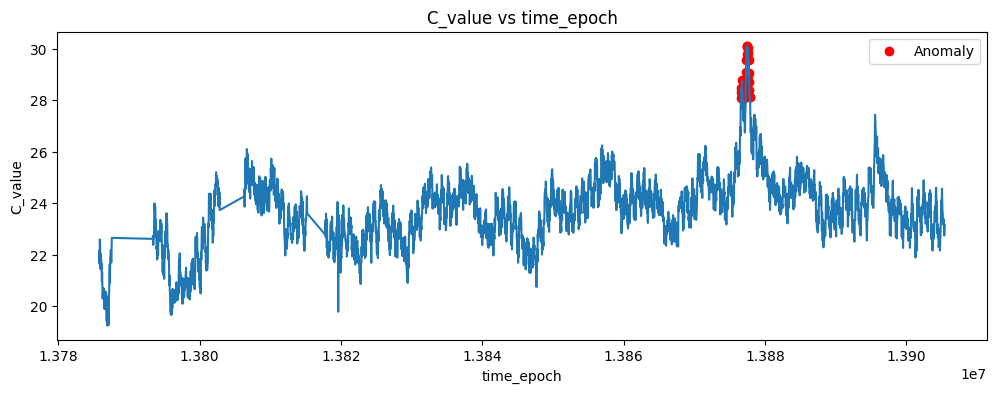

In [ ]:
#test_set_1에 대한 이상탐지 결과 plot(인덱스 1500~4500에 대해서)

# 그래프 크기 조정
plt.figure(figsize=(12, 4))

# 그래프 생성
plt.plot(data['time_epoch'][1500:4500], data['C_value'][1500:4500])
plt.xlabel('time_epoch')
plt.ylabel('C_value')
plt.title('C_value vs time_epoch')

#이상치 표시
anomaly_indices = anomalies + 1500  # test_set의 인덱스를 scaled_df 인덱스로 변환
for i in anomaly_indices:
  total_anomalies.append(i)
anomaly_indices = anomaly_indices[(anomaly_indices >= 1500) & (anomaly_indices <= 4500)]  # 인덱스 1500~4500 사이만 선택


plt.scatter(data['time_epoch'].iloc[anomaly_indices], data['C_value'].iloc[anomaly_indices], color='red', label='Anomaly')

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()

In [ ]:
#test_set_2 이상탐지

reconstructions_2 = model.predict(test_set_2)
mse = np.mean(np.power(test_set_2 - reconstructions_2, 2), axis=1)
threshold = np.mean(mse) + 3 * np.std(mse) #평균값으로 부터 멀 수록 이상치에 가깝다고 가정

anomalies = np.where(mse > threshold)[0]

print("test_set에 대한 이상 탐지 결과:")
print(anomalies)

71/71 [==============================] - 0s 2ms/step
test_set에 대한 이상 탐지 결과:
[1174 1175 1177 1178 1180 1181 1182 1183 1195 2019 2020 2021 2022 2023
 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037
 2038 2039 2040 2041 2042 2043 2063 2065 2169 2170 2171 2173 2185 2188
 2191 2194 2197 2198 2200 2202 2205 2206 2209 2210]


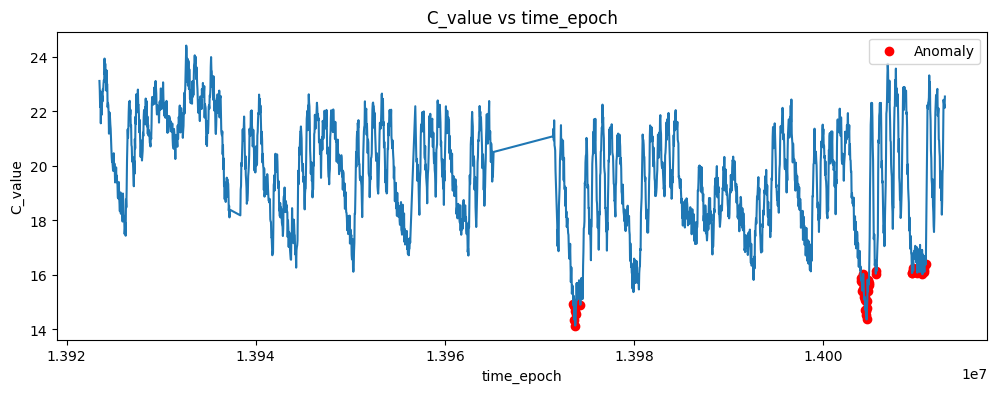

In [ ]:
#test_set_2에 대한 이상탐지 결과 plot(인덱스 5000~에 대해서)

# 그래프 크기 조정
plt.figure(figsize=(12, 4))

# 그래프 생성
plt.plot(data['time_epoch'][5000:], data['C_value'][5000:])
plt.xlabel('time_epoch')
plt.ylabel('C_value')
plt.title('C_value vs time_epoch')

#이상치 표시
anomaly_indices = anomalies + 5000  # test_set의 인덱스를 scaled_df 인덱스로 변환
anomaly_indices = anomaly_indices[(anomaly_indices >= 5000)]  # 인덱스 5000~ 선택
for i in anomaly_indices:
  total_anomalies.append(i)

plt.scatter(data['time_epoch'].iloc[anomaly_indices], data['C_value'].iloc[anomaly_indices], color='red', label='Anomaly')

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()

In [ ]:
print(total_anomalies)

[3698, 3699, 3700, 3701, 3702, 3703, 3704, 3706, 3717, 3718, 3719, 3720, 3721, 3722, 3723, 3724, 3725, 3726, 3727, 3728, 3729, 3730, 3731, 3732, 3733, 6174, 6175, 6177, 6178, 6180, 6181, 6182, 6183, 6195, 7019, 7020, 7021, 7022, 7023, 7024, 7025, 7026, 7027, 7028, 7029, 7030, 7031, 7032, 7033, 7034, 7035, 7036, 7037, 7038, 7039, 7040, 7041, 7042, 7043, 7063, 7065, 7169, 7170, 7171, 7173, 7185, 7188, 7191, 7194, 7197, 7198, 7200, 7202, 7205, 7206, 7209, 7210]


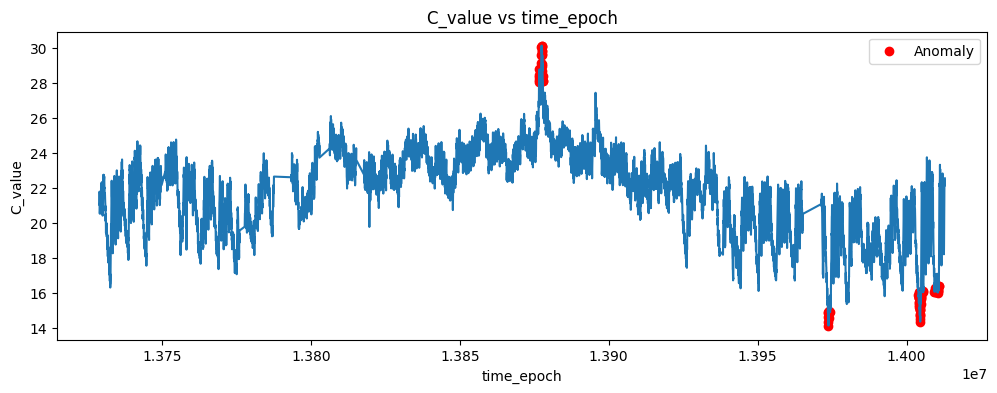

In [ ]:
#전체 데이터셋 이상치 표시

# 그래프 크기 조정
plt.figure(figsize=(12, 4))

# 그래프 생성
plt.plot(data['time_epoch'], data['C_value'])
plt.xlabel('time_epoch')
plt.ylabel('C_value')
plt.title('C_value vs time_epoch')

#이상치 표시
plt.scatter(data['time_epoch'].iloc[total_anomalies], data['C_value'].iloc[total_anomalies], color='red', label='Anomaly')

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()

#다른 데이터셋

In [ ]:
#데이터 읽기
df = pd.read_csv('realKnownCause/realKnownCause/machine_temperature_system_failure.csv')
"""
The first anomaly is a
planned shutdown of the machine. The second anomaly is difficult to detect and
directly led to the third anomaly, a catastrophic failure of the machine.
"""

'\nThe first anomaly is a\nplanned shutdown of the machine. The second anomaly is difficult to detect and\ndirectly led to the third anomaly, a catastrophic failure of the machine.\n'

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22695 entries, 0 to 22694
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  22695 non-null  object 
 1   value      22695 non-null  float64
dtypes: float64(1), object(1)
memory usage: 354.7+ KB


In [ ]:
df.describe

<bound method NDFrame.describe of                  timestamp      value
0      2013-12-02 21:15:00  73.967322
1      2013-12-02 21:20:00  74.935882
2      2013-12-02 21:25:00  76.124162
3      2013-12-02 21:30:00  78.140707
4      2013-12-02 21:35:00  79.329836
...                    ...        ...
22690  2014-02-19 15:05:00  98.185415
22691  2014-02-19 15:10:00  97.804168
22692  2014-02-19 15:15:00  97.135468
22693  2014-02-19 15:20:00  98.056852
22694  2014-02-19 15:25:00  96.903861

[22695 rows x 2 columns]>

<Axes: xlabel='timestamp'>

<Figure size 1200x600 with 0 Axes>

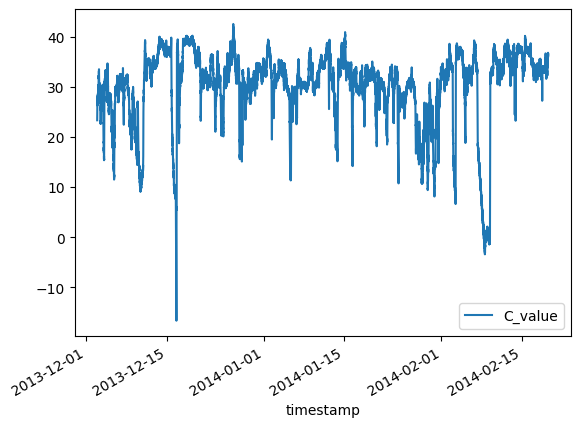

In [ ]:
#데이터 전처리
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['C_value'] = (df['value'] -32 )* (5/9) # 화씨 -> 섭씨

#전체 데이터 시각화
plt.figure(figsize=(12,6))
df.plot(x='timestamp', y='C_value')

그 전 그래프와 위의 그래프를 비교 및 분석해봤을 때, 10~40도 정도는 기계의 정상 운전 온도라고 가정.

2013-12-20 정도에 -10도를 planned shutdown of the machine으로 생각하고 진행

<Axes: xlabel='time_epoch'>

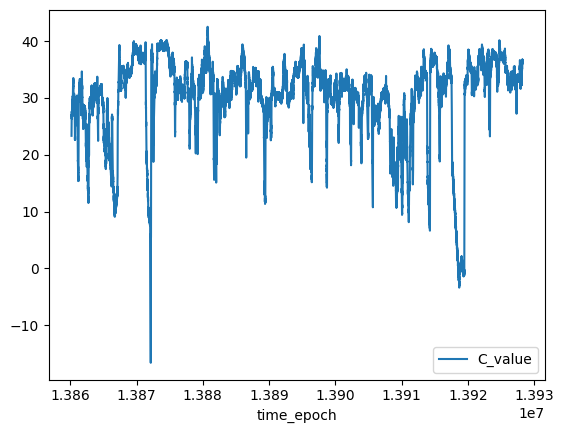

In [ ]:
#시간을 정수형으로 변환
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)
df.plot(x='time_epoch', y='C_value')

In [ ]:
#온도 최저점의 time_epoch 확인
data = df[['time_epoch','C_value']]
print(np.argmin(data['C_value']))

3986


최저점의 index가 3986이므로 약 3000까지는 정상 운전 데이터로 가정

Scaling을 진행한 정상 운전 데이터를 기반으로 LSTM 모델을 학습


In [ ]:
#Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
scaled_df = pd.DataFrame(scaled_data)
scaled_df.columns = [ 'time_epoch', 'C_value']

#train, test set 분리
train_set = scaled_df.iloc[:3000,:]
test_set = scaled_df.iloc[3000:,:]

#LSTM 라이브러리
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from keras.models import Sequential

# DataFrame을 배열로 변환
train_set_array = train_set.values

# 입력 데이터 형태 변환
train_set_array = train_set_array.reshape(train_set_array.shape[0], train_set_array.shape[1], 1)

# 모델 구성
model = Sequential()
model.add(LSTM(64, activation='relu'))
model.add(Dense(train_set_array.shape[1]))  # 유닛 수를 변경
model.compile(optimizer='adam', loss='mse')

# 모델 학습
model.fit(train_set_array, train_set_array, epochs=20, batch_size=32)

Epoch 1/20
94/94 [==============================] - 2s 3ms/step - loss: 0.1439
Epoch 2/20
94/94 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 3/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0035
Epoch 4/20
94/94 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 5/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0032
Epoch 6/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0031
Epoch 7/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0029
Epoch 8/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0027
Epoch 9/20
94/94 [==============================] - 0s 3ms/step - loss: 0.0025
Epoch 10/20
94/94 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 11/20
94/94 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 12/20
94/94 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 13/20
94/94 [==============================

In [ ]:
#test_set 이상탐지

reconstructions = model.predict(test_set)
mse = np.mean(np.power(test_set - reconstructions, 2), axis=1)
threshold = np.mean(mse) + 3 * np.std(mse) #평균값으로 부터 멀 수록 이상치에 가깝다고 가정

anomalies = np.where(mse > threshold)[0]

print("test_set에 대한 이상 탐지 결과:")
print(anomalies)


616/616 [==============================] - 1s 1ms/step
test_set에 대한 이상 탐지 결과:
[16339 16341 16344 16345 16346 16347 16349 16350 16351 16352 16353 16354
 16355 16356 16357 16358 16359 16360 16361 16362 16363 16364 16365 16366
 16367 16368 16369 16370 16371 16372 16373 16374 16375 16376 16377 16378
 16379 16380 16381 16382 16383 16384 16385 16386 16387 16388 16389 16390
 16391 16392 16393 16394 16395 16396 16397 16398 16399 16400 16401 16402
 16403 16404 16405 16406 16407 16408 16409 16410 16411 16412 16413 16414
 16415 16416 16417 16418 16419 16420 16421 16422 16423 16424 16425 16426
 16427 16428 16429 16430 16431 16432 16433 16434 16435 16436 16437 16438
 16439 16440 16441 16442 16443 16444 16445 16446 16447 16448 16449 16450
 16451 16452 16453 16454 16455 16456 16457 16458 16459 16460 16461 16462
 16463 16464 16465 16466 16467 16468 16469 16470 16471 16472 16473 16474
 16475 16476 16477 16478 16479 16480 16481 16482 16483 16484 16485 16486
 16487 16488 16489 16490 16491 16492 16493 164

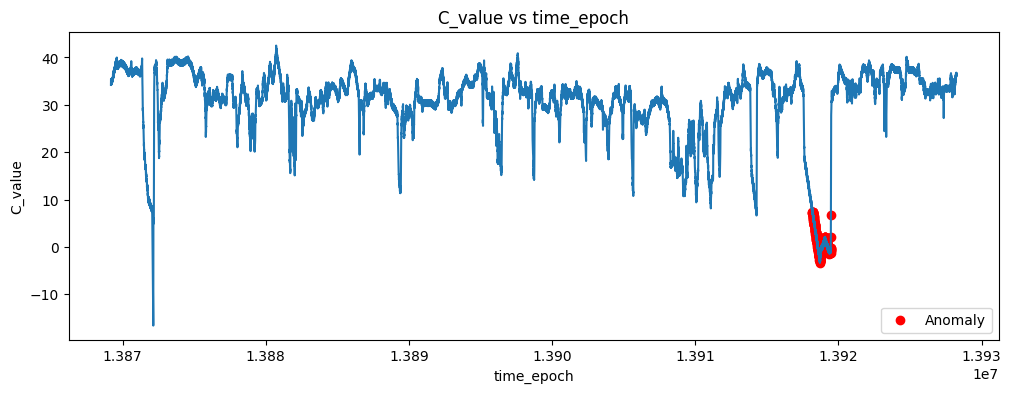

In [ ]:
#test_set에 대한 이상탐지 결과 plot(인덱스 3000~)

# 그래프 크기 조정
plt.figure(figsize=(12, 4))

# 그래프 생성
plt.plot(data['time_epoch'][3000:], data['C_value'][3000:])
plt.xlabel('time_epoch')
plt.ylabel('C_value')
plt.title('C_value vs time_epoch')

#이상치 표시
anomaly_indices = anomalies + 3000  # test_set의 인덱스를 scaled_df 인덱스로 변환
anomaly_indices = anomaly_indices[(anomaly_indices >= 3000)]

plt.scatter(data['time_epoch'].iloc[anomaly_indices], data['C_value'].iloc[anomaly_indices], color='red', label='Anomaly')

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()